# CNN Image Classification Laboration


Images used in this laboration are from CIFAR 10 (https://en.wikipedia.org/wiki/CIFAR-10). The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Your task is to make a classifier, using a convolutional neural network, that can correctly classify each image into the correct class.

You need to answer all questions in this notebook. 

## Part 1: What is a convolution

To understand a bit more about convolutions, we will first test the convolution function in scipy using a number of classical filters. 

Convolve the image with Gaussian filter, a Sobel X filter, and a Sobel Y filter, using the function 'convolve2d' in 'signal' from scipy.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In a CNN, many filters are applied in each layer, and the filter coefficients are learned through back propagation (which is in contrast to traditional image processing, where the filters are designed by an expert).

In [1]:
# This cell is finished

from scipy import signal
import numpy as np

# Get a test image
from scipy import misc
image = misc.ascent()

# Define a help function for creating a Gaussian filter
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Create Gaussian filter with certain size and standard deviation
gaussFilter = matlab_style_gauss2D((15,15),4)

# Define filter kernels for SobelX and Sobely
sobelX = np.array([[ 1, 0,  -1],
                    [2, 0, -2],
                    [1, 0, -1]]) 

sobelY = np.array([[ 1, 2,  1],
                    [0, 0, 0],
                    [-1, -2, -1]]) 

In [2]:
# Perform convolution using the function 'convolve2d' for the different filters
filterResponseGauss = signal.convolve2d(image, gaussFilter)
filterResponseSobelX = signal.convolve2d(image, sobelX)
filterResponseSobelY = signal.convolve2d(image, sobelY) 

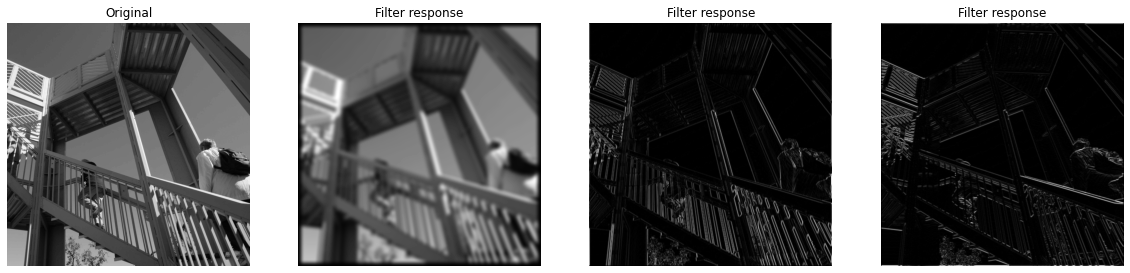

In [3]:
import matplotlib.pyplot as plt

# Show filter responses
fig, (ax_orig, ax_filt1, ax_filt2, ax_filt3) = plt.subplots(1, 4, figsize=(20, 6))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_filt1.imshow(np.absolute(filterResponseGauss), cmap='gray')
ax_filt1.set_title('Filter response')
ax_filt1.set_axis_off()
ax_filt2.imshow(np.absolute(filterResponseSobelX), cmap='gray')
ax_filt2.set_title('Filter response')
ax_filt2.set_axis_off()
ax_filt3.imshow(np.absolute(filterResponseSobelY), cmap='gray')
ax_filt3.set_title('Filter response')
ax_filt3.set_axis_off()

##  Part 2: Understanding convolutions

Question 1: What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?
Answer : Guassian filter blurs the original image. This can be useful to reduce the level of noise. SobelX and SobelY is used for edge detection.

Question 2: What is the size of the original image? How many channels does it have? How many channels does a color image normally have?
Answer : Size of the original image is 512x512. Normally color image have 3 channels but as it is in gray scale it has 1 channel.

Question 3: What is the size of the different filters?
Answer: Guassian filter is 15x15. SobelX and SobelY is 3x3.

Question 4: What is the size of the filter response if mode 'same' is used for the convolution ?
Answer : The size of the filter response if mode 'same' is used for the convolution is same as the input. 

Question 5: What is the size of the filter response if mode 'valid' is used for the convolution? How does the size of the valid filter response depend on the size of the filter? 
Answer : (Size of filter - 1) pixels smaller.

Question 6: Why are 'valid' convolutions a problem for CNNs with many layers?
Answer : In every convolution layer, we loose (Size of filter - 1) pixels when valid padding is used. Eventually we run out of pixels.

In [4]:
# Your code for checking sizes of image and filter responses

print("Original image size {}".format(image.shape))
print("GaussFilter response image size {}".format(filterResponseGauss.shape))
print("SobelXFilter response image size {}".format(filterResponseSobelX.shape))
print("SobelYFilter respomse image size {}".format(filterResponseSobelY.shape))

Original image size (512, 512)
GaussFilter response image size (526, 526)
SobelXFilter response image size (514, 514)
SobelYFilter respomse image size (514, 514)


##  Part 3: Get a graphics card

Skip this part if you run on a CPU

Let's make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming convolutions in every training iteration.

In [ ]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

##  Part 4: How fast is the graphics card?

Question 7: Why are the filters of size 7 x 7 x 3, and not 7 x 7 ? 
Answer : 3 channels represents the color.

Question 8: What operation is performed by the 'Conv2D' layer? Is it a standard 2D convolution, as performed by the function signal.convolve2d we just tested?
Answer : 'convolve2d' inverts the kernel before applying the convolution but in case of 'Conv2D' it does not invert.

Lets investigate how much faster a convolution is with the graphics card (skip this part if you run on a CPU)

Question 9: How much faster is the graphics card, compared to the CPU, for convolving a batch of 100 images?

Question 10: How much faster is the graphics card, compared to the CPU, for convolving a batch of 2 images? Explain the difference compared to 100 images.

In [5]:
# Run this cell to compare processing time of CPU and GPU

import timeit

n_images_in_batch = 100

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Perform convolutions using the CPU
def cpu():
  with tf.device('/cpu:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_cpu)

# Perform convolutions using the GPU (graphics card)
def gpu():
  with tf.device('/device:GPU:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the convolution several times and measure the time
print('Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3'
      ' (batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

NameError: name 'tf' is not defined

##  Part 5:  Load data
Time to make a 2D CNN. Load the images and labels from keras.datasets, this cell is already finished.

In [5]:
from keras.datasets import cifar10
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

print("Training images have size {} and labels have size {} ".format(Xtrain.shape, Ytrain.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

# Reduce the number of images for training and testing to 10000 and 2000 respectively, 
# to reduce processing time for this laboration
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

Ytestint = Ytest

print("Reduced training images have size %s and labels have size %s " % (Xtrain.shape, Ytrain.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training examples for class {} is {}" .format(i,np.sum(Ytrain == i)))

Training images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 
Reduced training images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training examples for class 0 is 1005
Number of training examples for class 1 is 974
Number of training examples for class 2 is 1032
Number of training examples for class 3 is 1016
Number of training examples for class 4 is 999
Number of training examples for class 5 is 937
Number of training examples for class 6 is 1030
Number of training examples for class 7 is 1001
Number of training examples for class 8 is 1025
Number of training examples for class 9 is 981


##  Part 6: Plotting

Lets look at some of the training examples, this cell is already finished. You will see different examples every time you run the cell.

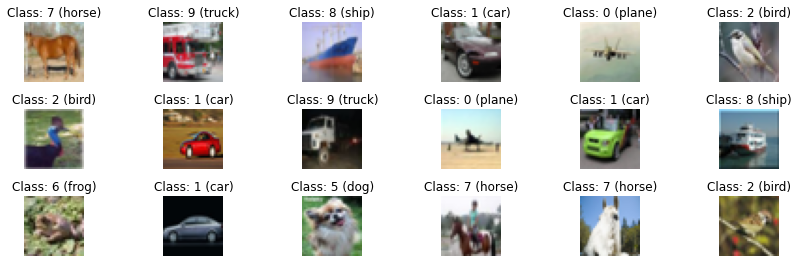

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(18):
    idx = np.random.randint(7500)
    label = Ytrain[idx,0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(Xtrain[idx])
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

##   Part 7: Split data into training, validation and testing
Split your training data into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration). We use a function in scikit learn. Use 25% of the data for validation.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [7]:
from sklearn.model_selection import train_test_split

# Print the size of training data, validation data and test data
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.25, shuffle = True, random_state = 123)

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xval has size {}.'.format(Xval.shape))
print('Yval has size {}.'.format(Yval.shape))


Xtrain has size (7500, 32, 32, 3).
Ytrain has size (7500, 1).
Xval has size (2500, 32, 32, 3).
Yval has size (2500, 1).


##  Part 8: Preprocessing of images

Lets perform some preprocessing. The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255. This cell is already finished.

In [8]:
# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

##  Part 9: Preprocessing of labels

The labels (Y) need to be converted from e.g. '4' to "hot encoded", i.e. to a vector of type [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] . We use a function in Keras, see https://keras.io/api/utils/python_utils/#to_categorical-function

In [9]:
from keras.utils import to_categorical

# Print shapes before converting the labels
print('Ytrain has size {}.'.format(Ytrain.shape))
print('Yval has size {}.'.format(Yval.shape))
print('Ytest has size {}.'.format(Ytest.shape))

# Your code for converting Ytrain, Yval, Ytest to categorical
y_train_c = to_categorical(Ytrain, num_classes=10)
y_val_c = to_categorical(Yval, num_classes=10)
y_test_c  = to_categorical(Ytest , num_classes=10)

# Print shapes after converting the labels
print('Ytrain_c has size {}.'.format(y_train_c.shape))
print('Yval_c has size {}.'.format(y_val_c.shape))
print('Ytest_c has size {}.'.format(y_test_c.shape))

Ytrain has size (7500, 1).
Yval has size (2500, 1).
Ytest has size (2000, 1).
Ytrain_c has size (7500, 10).
Yval_c has size (2500, 10).
Ytest_c has size (2000, 10).


##  Part 10: 2D CNN
Finish this code to create the image classifier, using a 2D CNN. Each convolutional layer will contain 2D convolution, batch normalization and max pooling. After the convolutional layers comes a flatten layer and a number of intermediate dense layers. The convolutional layers should take the number of filters as an argument, use a kernel size of 3 x 3, 'same' padding, and relu activation functions. The number of filters will double with each convolutional layer. The max pooling layers should have a pool size of 2 x 2. The intermediate dense layers before the final dense layer should take the number of nodes as an argument, use relu activation functions, and be followed by batch normalization. The final dense layer should have 10 nodes (= the number of classes in this laboration) and 'softmax' activation. Here we start with the Adam optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`Conv2D()`, performs 2D convolutions with a number of filters with a certain size (e.g. 3 x 3). 

`BatchNormalization()`, perform batch normalization

`MaxPooling2D()`, saves the max for a given pool size, results in down sampling

`Flatten()`, flatten a multi-channel tensor into a long vector

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/api/layers/core_layers/dense/ and https://keras.io/api/layers/reshaping_layers/flatten/ for information on how the `Dense()` and `Flatten()` functions work

See https://keras.io/layers/convolutional/ for information on how `Conv2D()` works

See https://keras.io/layers/pooling/ for information on how `MaxPooling2D()` works

Import a relevant cost function for multi-class classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

In [43]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01,
              use_batch = True, act_fun = "relu"):

    # Setup a sequential model
    model = Sequential()

    # Add first convolutional layer to the model, requires input shape
    
    model.add(Conv2D(n_filters, (3,3), padding = "same", activation = act_fun,input_shape=input_shape ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if use_batch:
        model.add(BatchNormalization())
        
    # Add remaining convolutional layers to the model, the number of filters should increase a factor 2 for each layer
    for i in range(n_conv_layers-1):
        n_filters = 2*n_filters 
        model.add(Conv2D(n_filters, (3,3), padding = "same", activation = act_fun))
        if use_batch:
            model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Add flatten layer
    model.add(Flatten())

    # Add intermediate dense layers
    for i in range(n_dense_layers):
        model.add(Dense(n_nodes,activation = act_fun))
        if use_batch:
            model.add(BatchNormalization())
        if use_dropout:
            model.add(Dropout(rate = 0.5))
            
    # Add final dense layer
   
    model.add(Dense(10,activation = "softmax"))
    # Compile model
    opt  = Adam(learning_rate=learning_rate)
    model.compile(opt,loss=categorical_crossentropy,metrics=['accuracy'])
    return model

In [44]:
# Lets define a help function for plotting the training results
import matplotlib.pyplot as plt
def plot_results(history):
    
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()
    
    

## Part 11: Train 2D CNN

Time to train the 2D CNN, start with 2 convolutional layers, no intermediate dense layers, learning rate = 0.01. The first convolutional layer should have 16 filters (which means that the second convolutional layer will have 32 filters).

Relevant functions

`build_CNN`, the function we defined in Part 10, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

## 2 convolutional layers, no intermediate dense layers

In [12]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:4]

# Build model
model1 = build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50)

# Train the model  using training data and validation data
history1 = model1.fit(Xtrain,y_train_c,epochs = epochs,validation_data = (Xval, y_val_c),batch_size=batch_size) 

Epoch 1/20
75/75 [==============================] - 12s 165ms/step - loss: 3.0517 - accuracy: 0.3115 - val_loss: 2.5509 - val_accuracy: 0.2596
Epoch 2/20
75/75 [==============================] - 12s 155ms/step - loss: 1.6398 - accuracy: 0.4472 - val_loss: 1.7337 - val_accuracy: 0.3720
Epoch 3/20
75/75 [==============================] - 12s 156ms/step - loss: 1.2900 - accuracy: 0.5497 - val_loss: 1.6319 - val_accuracy: 0.4040
Epoch 4/20
75/75 [==============================] - 11s 150ms/step - loss: 1.1188 - accuracy: 0.6085 - val_loss: 1.3846 - val_accuracy: 0.5076
Epoch 5/20
75/75 [==============================] - 11s 149ms/step - loss: 1.0167 - accuracy: 0.6440 - val_loss: 1.3700 - val_accuracy: 0.5300
Epoch 6/20
75/75 [==============================] - 11s 151ms/step - loss: 0.9244 - accuracy: 0.6689 - val_loss: 1.3143 - val_accuracy: 0.5840
Epoch 7/20
75/75 [==============================] - 11s 150ms/step - loss: 0.8346 - accuracy: 0.7033 - val_loss: 1.2762 - val_accuracy: 0.5868

In [13]:
# Evaluate the trained model on test set, not used in training or validation
score = model1.evaluate(Xtest,y_test_c)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 1s 16ms/step - loss: 2.9756 - accuracy: 0.5170 0s - loss: 3.0608 - accuracy:  - ETA: 0s - loss: 2.9796 - accuracy: 
Test loss: 2.9756
Test accuracy: 0.5170


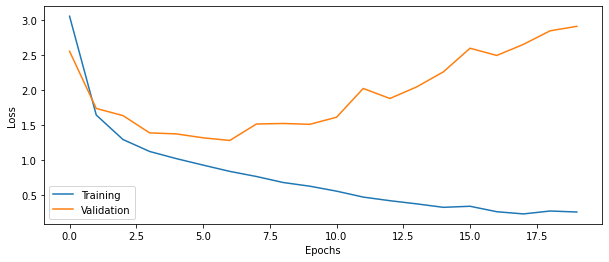

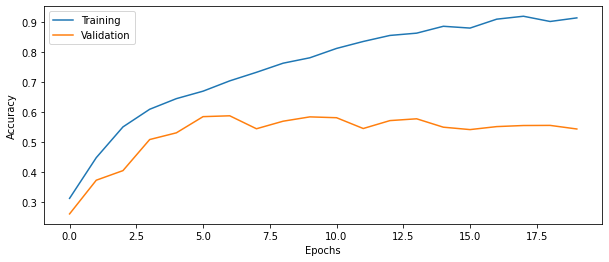

In [14]:
# Plot the history from the training run
plot_results(history1)

## Part 12: Improving performance

Skip question 12 if you run on a CPU

Write down the test accuracy, are you satisfied with the classifier performance (random chance is 10%) ? 
Answer : Test accuracy is 53%. Not satisfied with the classifier performance.

Question 11: How big is the difference between training and test accuracy?
Answer : Train Accuracy : 91%
Test Accuracy : 53%
There is around 40% difference between train and test accuracy.

Question 12: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'watch nvidia-smi' on the cloud computer during training. 

Question 13: For the DNN laboration we used a batch size of 10,000, why do we need to use a smaller batch size in this laboration?
Answer : Here the data is colored image, which is high dimensional as compared to previous data. Hence it is ideal to use smaller batch size.

## 2 convolutional layers, 1 intermediate dense layer (50 nodes)

In [43]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:4]

# Build model
model2 = build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=1, n_nodes=50)

# Train the model  using training data and validation data
history2 = model2.fit(Xtrain,y_train_c,epochs = epochs,validation_data = (Xval, y_val_c),batch_size=batch_size) 

Epoch 1/20
75/75 [==============================] - 10s 128ms/step - loss: 1.6626 - accuracy: 0.4077 - val_loss: 2.1827 - val_accuracy: 0.2272
Epoch 2/20
75/75 [==============================] - 10s 131ms/step - loss: 1.2831 - accuracy: 0.5377 - val_loss: 2.2780 - val_accuracy: 0.3048
Epoch 3/20
75/75 [==============================] - 9s 126ms/step - loss: 1.0711 - accuracy: 0.6177 - val_loss: 2.2567 - val_accuracy: 0.3916
Epoch 4/20
75/75 [==============================] - 8s 104ms/step - loss: 0.8837 - accuracy: 0.6821 - val_loss: 1.8427 - val_accuracy: 0.4480
Epoch 5/20
75/75 [==============================] - 7s 98ms/step - loss: 0.7323 - accuracy: 0.7452 - val_loss: 1.4744 - val_accuracy: 0.5428
Epoch 6/20
75/75 [==============================] - 9s 115ms/step - loss: 0.6259 - accuracy: 0.7812 - val_loss: 1.5026 - val_accuracy: 0.5732
Epoch 7/20
75/75 [==============================] - 7s 100ms/step - loss: 0.4302 - accuracy: 0.8513 - val_loss: 1.8095 - val_accuracy: 0.5600
Epoch

In [44]:
# Evaluate the trained model on test set, not used in training or validation
score = model2.evaluate(Xtest,y_test_c)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 0s 6ms/step - loss: 3.4133 - accuracy: 0.5570
Test loss: 3.4133
Test accuracy: 0.5570


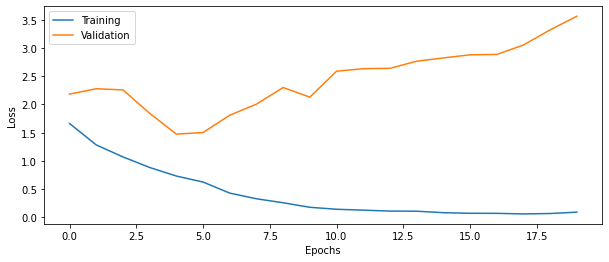

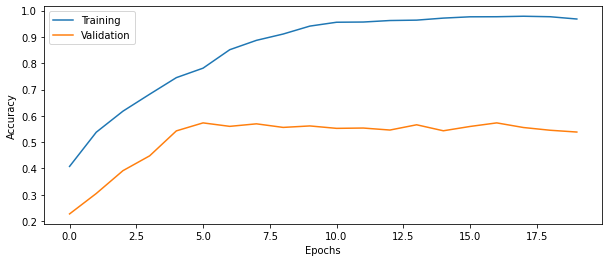

In [45]:
# Plot the history from the training run
plot_results(history2)

## 4 convolutional layers, 1 intermediate dense layer (50 nodes)

In [46]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:4]

# Build model
model3 = build_CNN(input_shape, n_conv_layers=4, n_filters=16, n_dense_layers=1, n_nodes=50)

# Train the model  using training data and validation data
history3 = model3.fit(Xtrain,y_train_c,epochs = epochs,validation_data = (Xval, y_val_c),batch_size=batch_size) 

Epoch 1/20
75/75 [==============================] - 12s 158ms/step - loss: 1.7801 - accuracy: 0.3527 - val_loss: 1.9897 - val_accuracy: 0.2976
Epoch 2/20
75/75 [==============================] - 12s 160ms/step - loss: 1.4264 - accuracy: 0.4783 - val_loss: 1.9397 - val_accuracy: 0.3712
Epoch 3/20
75/75 [==============================] - 10s 138ms/step - loss: 1.2239 - accuracy: 0.5549 - val_loss: 1.7375 - val_accuracy: 0.4388
Epoch 4/20
75/75 [==============================] - 9s 119ms/step - loss: 1.0447 - accuracy: 0.6239 - val_loss: 1.6055 - val_accuracy: 0.5072
Epoch 5/20
75/75 [==============================] - 9s 123ms/step - loss: 0.9153 - accuracy: 0.6713 - val_loss: 1.5383 - val_accuracy: 0.5368
Epoch 6/20
75/75 [==============================] - 10s 131ms/step - loss: 0.7776 - accuracy: 0.7235 - val_loss: 1.6529 - val_accuracy: 0.5576
Epoch 7/20
75/75 [==============================] - 9s 122ms/step - loss: 0.6409 - accuracy: 0.7732 - val_loss: 1.8785 - val_accuracy: 0.5508
Ep

In [47]:
# Evaluate the trained model on test set, not used in training or validation
score = model3.evaluate(Xtest,y_test_c)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 1s 12ms/step - loss: 2.2653 - accuracy: 0.6025
Test loss: 2.2653
Test accuracy: 0.6025


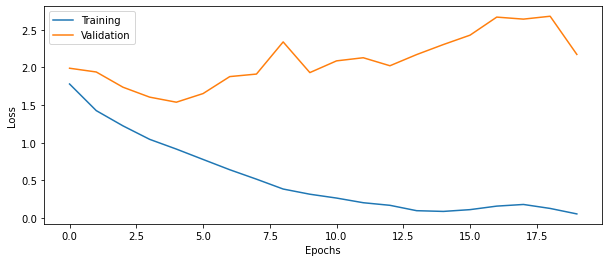

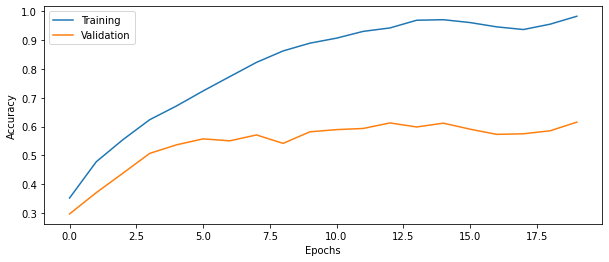

In [48]:
# Plot the history from the training run
plot_results(history3)

##  Part 13: Plot the CNN architecture

To understand your network better, print the architecture using `model.summary()`

Question 14: How many trainable parameters does your network have? Which part of the network contains most of the parameters?
Answer : 124,180 trainable parameters. conv2d_12 (Conv2D) contains most of the parameters.

Question 15: What is the input to and output of a Conv2D layer? What are the dimensions of the input and output? 
Answer : input: 32 X 32 X 3 and output : 32 X 32 X 16

Question 16: Is the batch size always the first dimension of each 4D tensor? Check the documentation for Conv2D, https://keras.io/layers/convolutional/
Answer : The contents of 4D tensor are either batch_size, height, width, channels or batch_size, channels, height, width. Either way first dimension of 4D tensor is batch size.


Question 17: If a convolutional layer that contains 128 filters is applied to an input with 32 channels, what is the number of channels in the output?
Answer : 128 X 32

Question 18: Why is the number of parameters in each Conv2D layer *not* equal to the number of filters times the number of filter coefficients per filter (plus biases)?
Answer: 16 filters of size 3 x 3 x 3, 448 parameters (weights per layer for CNN (432 + 16 bias) = 448). Conv2D performs 3D convolution and learns one filter per input channel

Question 19: How does MaxPooling help in reducing the number of parameters to train?
Answer : MaxPooling performs dimensionality reduction by picking out the max value in every slide after an image goes through the filter. Hence reduces the dimensionality.

In [49]:
# Print network architecture

model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)         

##  Part 14: Dropout regularization

Add dropout regularization to each intermediate dense layer, dropout probability 50%.

Question 20: How much did the test accuracy improve with dropout, compared to without dropout?
Answer : Not much improvement. Test accuracy improved by 1 %.

Question 21: What other types of regularization can be applied? How can you add L2 regularization for the convolutional layers?
Answer : We set the parameters in the convolutional layer to 'kernel_regularizer','bias_regularizer' or 'activity_regularizer' with a penalty factor to perform L2 regularization.

## 4 convolutional layers, 1 intermediate dense layer (50 nodes), dropout

In [16]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:4]

# Build model
model4 = build_CNN(input_shape, n_conv_layers=4, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=True)

# Train the model  using training data and validation data
history4 = model4.fit(Xtrain,y_train_c,epochs = epochs,validation_data = (Xval, y_val_c),batch_size=batch_size) 

Epoch 1/20
75/75 [==============================] - 16s 211ms/step - loss: 2.0364 - accuracy: 0.2861 - val_loss: 2.0067 - val_accuracy: 0.2864
Epoch 2/20
75/75 [==============================] - 17s 221ms/step - loss: 1.5853 - accuracy: 0.3963 - val_loss: 2.0745 - val_accuracy: 0.2656
Epoch 3/20
75/75 [==============================] - 13s 173ms/step - loss: 1.4396 - accuracy: 0.4631 - val_loss: 1.6353 - val_accuracy: 0.4184
Epoch 4/20
75/75 [==============================] - 13s 170ms/step - loss: 1.3203 - accuracy: 0.5177 - val_loss: 1.3768 - val_accuracy: 0.5204
Epoch 5/20
75/75 [==============================] - 13s 169ms/step - loss: 1.1813 - accuracy: 0.5697 - val_loss: 1.3379 - val_accuracy: 0.5288
Epoch 6/20
75/75 [==============================] - 11s 153ms/step - loss: 1.0790 - accuracy: 0.6060 - val_loss: 1.9195 - val_accuracy: 0.4900
Epoch 7/20
75/75 [==============================] - 11s 149ms/step - loss: 0.9734 - accuracy: 0.6485 - val_loss: 1.5569 - val_accuracy: 0.5384

In [17]:
# Evaluate the trained model on test set, not used in training or validation
score = model4.evaluate(Xtest,y_test_c)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 1s 16ms/step - loss: 2.2242 - accuracy: 0.6125
Test loss: 2.2242
Test accuracy: 0.6125


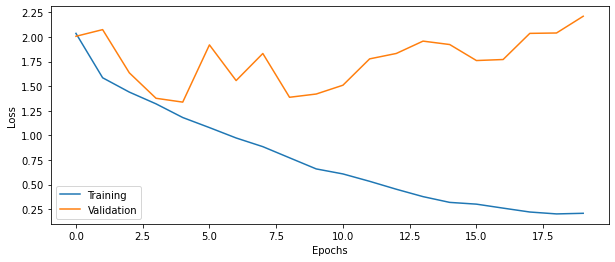

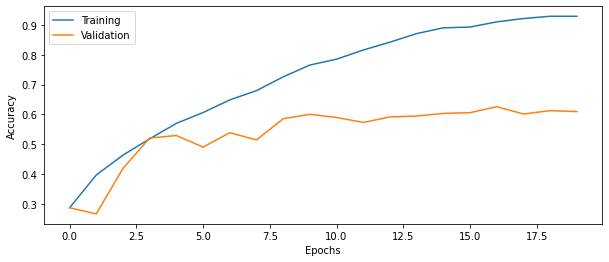

In [18]:
# Plot the history from the training run
plot_results(history4)

##  Part 15: Tweaking performance

You have now seen the basic building blocks of a 2D CNN. To further improve performance involves changing the number of convolutional layers, the number of filters per layer, the number of intermediate dense layers, the number of nodes in the intermediate dense layers, batch size, learning rate, number of epochs, etc. Spend some time (30 - 90 minutes) testing different settings.

Question 22: How high test accuracy can you obtain? What is your best configuration?
Answer: We got 0.6370 test accuracy.
Best configuration :
n_conv_layers=4, n_filters=64, n_dense_layers=2, n_nodes=300, use_dropout=True

## Your best config

In [18]:
# Setup some training parameters

batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:4]

# Build model
model5 = build_CNN(input_shape, n_conv_layers=4, n_filters=64, n_dense_layers=2, n_nodes=300, use_dropout=True)

# Train the model  using training data and validation data
history5 = model5.fit(Xtrain,y_train_c,epochs = epochs,validation_data = (Xval, y_val_c),batch_size=batch_size) 

Epoch 1/20
75/75 [==============================] - 109s 1s/step - loss: 2.3969 - accuracy: 0.2477 - val_loss: 2.6825 - val_accuracy: 0.2688
Epoch 2/20
75/75 [==============================] - 108s 1s/step - loss: 1.8277 - accuracy: 0.3465 - val_loss: 3.4588 - val_accuracy: 0.1640
Epoch 3/20
75/75 [==============================] - 89s 1s/step - loss: 1.6378 - accuracy: 0.3971 - val_loss: 2.3376 - val_accuracy: 0.2524
Epoch 4/20
75/75 [==============================] - 60s 803ms/step - loss: 1.5074 - accuracy: 0.4369 - val_loss: 1.8309 - val_accuracy: 0.3468
Epoch 5/20
75/75 [==============================] - 61s 807ms/step - loss: 1.3751 - accuracy: 0.4949 - val_loss: 1.9720 - val_accuracy: 0.3848
Epoch 6/20
75/75 [==============================] - 61s 814ms/step - loss: 1.2347 - accuracy: 0.5503 - val_loss: 1.5523 - val_accuracy: 0.4740
Epoch 7/20
75/75 [==============================] - 61s 813ms/step - loss: 1.1259 - accuracy: 0.5959 - val_loss: 1.5943 - val_accuracy: 0.4868
Epoch 

In [19]:
# Evaluate the trained model on test set, not used in training or validation
score = model5.evaluate(Xtest,y_test_c)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 3s 40ms/step - loss: 1.9882 - accuracy: 0.6370
Test loss: 1.9882
Test accuracy: 0.6370


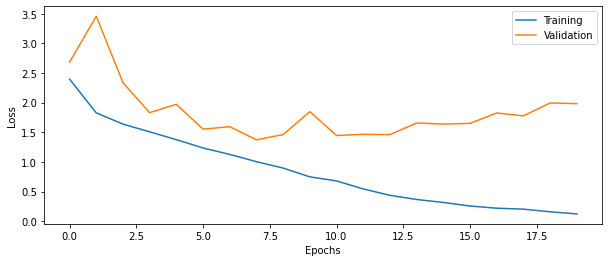

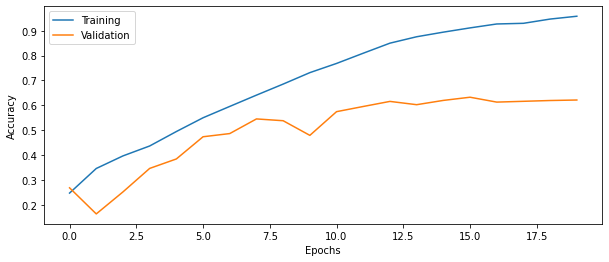

In [20]:
# Plot the history from the training run
plot_results(history5)

##  Part 16: Rotate the test images

How high is the test accuracy if we rotate the test images? In other words, how good is the CNN at generalizing to rotated images?

Rotate each test image 90 degrees, the cells are already finished.

Question 23: What is the test accuracy for rotated test images, compared to test images without rotation? Explain the difference in accuracy.
Answer : As our model is not trained on rotated images it is not able to classify the rotated images correctly. Hence, we are getting lower test accuracy(0.2130) for model with rotated test images when compared to the result without rotation(0.62).

In [21]:
def myrotate(images):

    images_rot = np.rot90(images, axes=(1,2))
    
    return images_rot

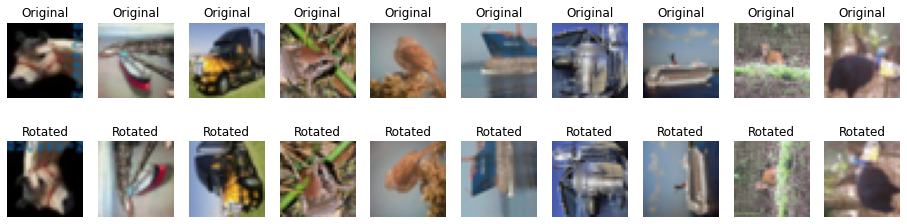

In [22]:
# Rotate the test images 90 degrees
Xtest_rotated = myrotate(Xtest)

# Look at some rotated images
plt.figure(figsize=(16,4))
for i in range(10):
    idx = np.random.randint(500)
    
    plt.subplot(2,10,i+1)
    plt.imshow(Xtest[idx]/2+0.5)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(Xtest_rotated[idx]/2+0.5)
    plt.title("Rotated")
    plt.axis('off')
plt.show()


In [23]:
# Evaluate the trained model on rotated test set
score = model5.evaluate(Xtest_rotated,y_test_c)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 2s 38ms/step - loss: 6.1296 - accuracy: 0.2030
Test loss: 6.1296
Test accuracy: 0.2030


##  Part 17: Augmentation using Keras `ImageDataGenerator`

We can increase the number of training images through data augmentation (we now ignore that CIFAR10 actually has 60 000 training images). Image augmentation is about creating similar images, by performing operations such as rotation, scaling, elastic deformations and flipping of existing images. This will prevent overfitting, especially if all the training images are in a certain orientation.

We will perform the augmentation on the fly, using a built-in function in Keras, called `ImageDataGenerator`

See https://keras.io/preprocessing/image/ , the `flow` method should be used

Do *NOT* use use_multiprocessing=True here, as it can cause strange errors.

In [45]:
# Get all 60 000 training images again. ImageDataGenerator manages validation data on its own
(Xtrain, Ytrain), _ = cifar10.load_data()

# Reduce number of images to 10,000
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

# Change data type and rescale range
Xtrain = Xtrain.astype('float32')
Xtrain = Xtrain / 127.5 - 1

# Convert labels to hot encoding
Ytrain = to_categorical(Ytrain, 10)

In [46]:
# Set up a data generator with on-the-fly data augmentation, 20% validation split
# Use a rotation range of 30 degrees, horizontal and vertical flipping
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(validation_split=0.2,rotation_range=30,horizontal_flip=True,vertical_flip=True)

# Setup a flow for training data, assume that we can fit all images into CPU memory

train_generator = datagen.flow(Xtrain, Ytrain, batch_size=100,subset= 'training')

# Setup a flow for validation data, assume that we can fit all images into CPU memory

val_generator = datagen.flow(Xval, Yval, batch_size=100,subset='validation')


## Part 18: What about big data?

Question 24: How would you change the code for the image generator if you cannot fit all training images in CPU memory? What is the disadvantage of doing that change?
Answer: This can be done by our own custom generator which loads the dataset from hard disk but this will be slower compared to load the data from CPU.

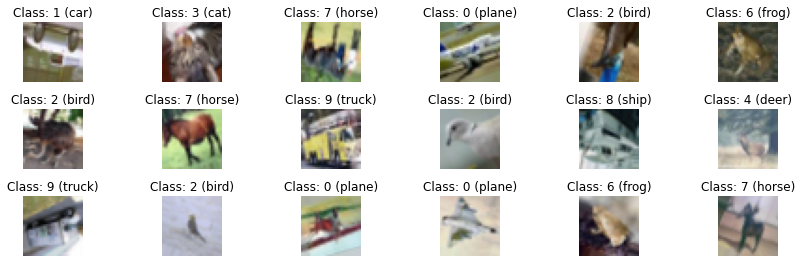

In [47]:
# Plot some augmented images
plot_datagen = datagen.flow(Xtrain, Ytrain, batch_size=1)

plt.figure(figsize=(12,4))
for i in range(18):
    (im, label) = plot_datagen.next()
    im = (im[0] + 1) * 127.5
    im = im.astype('int')
    label = np.flatnonzero(label)[0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

## Part 19: Train the CNN with images from the generator

See https://keras.io/api/models/model_training_apis/#fit-method for how to use model.fit with a generator instead of a fix dataset (numpy arrays)

To make the comparison fair to training without augmentation

    steps_per_epoch should be set to: len(Xtrain)*(1 - validation_split)/batch_size

    validation_steps should be set to: len(Xtrain)*validation_split/batch_size

Question 25: How quickly is the training accuracy increasing compared to without augmentation? Explain why there is a difference compared to without augmentation. What parameter is necessary to change to perform more training?
Answer : Training accuracy increases quickly when train the model without augmentation compared to accuracy with augumentation. Without augumentation the same images are shown repeatedly whereas with augumentaion we can show same image  with different versions (ex - the image with rotation or the same image with different brightness etc).

Question 26: What other types of image augmentation can be applied, compared to what we use here?
Answer : Image shifting, rotations, brightness, zoom

In [55]:
batch_size = 100
epochs = 200
input_shape = Xtrain.shape[1:4]

# Build model
model6 = build_CNN(input_shape, n_conv_layers=4, n_filters=32, n_dense_layers=2, n_nodes=70, use_dropout=True, act_fun = "linear")

validation_split=0.2

# Train the model using on the fly augmentation 
history6 = model6.fit(train_generator, steps_per_epoch=len(Xtrain)*(1 - validation_split)/batch_size, validation_data=val_generator,
                                validation_steps=len(Xtrain)*validation_split/batch_size, epochs=epochs)

Epoch 1/200
80/80 [==============================] - 18s 228ms/step - loss: 2.2407 - accuracy: 0.2114 - val_loss: 274.2556 - val_accuracy: 0.0000e+00
Epoch 2/200
80/80 [==============================] - 17s 218ms/step - loss: 1.8842 - accuracy: 0.2788
Epoch 3/200
80/80 [==============================] - 17s 218ms/step - loss: 1.7899 - accuracy: 0.3291
Epoch 4/200
80/80 [==============================] - 17s 218ms/step - loss: 1.7436 - accuracy: 0.3436
Epoch 5/200
80/80 [==============================] - 18s 219ms/step - loss: 1.6848 - accuracy: 0.3728
Epoch 6/200
80/80 [==============================] - 17s 218ms/step - loss: 1.6353 - accuracy: 0.3971
Epoch 7/200
80/80 [==============================] - 18s 224ms/step - loss: 1.6090 - accuracy: 0.4056
Epoch 8/200
80/80 [==============================] - 17s 218ms/step - loss: 1.5940 - accuracy: 0.4106
Epoch 9/200
80/80 [==============================] - 17s 217ms/step - loss: 1.5563 - accuracy: 0.4305
Epoch 10/200
80/80 [==============

80/80 [==============================] - 18s 231ms/step - loss: 0.8571 - accuracy: 0.6982
Epoch 77/200
80/80 [==============================] - 19s 241ms/step - loss: 0.8852 - accuracy: 0.6896
Epoch 78/200
80/80 [==============================] - 18s 230ms/step - loss: 0.8487 - accuracy: 0.7054
Epoch 79/200
80/80 [==============================] - 19s 234ms/step - loss: 0.8543 - accuracy: 0.7039
Epoch 80/200
80/80 [==============================] - 19s 232ms/step - loss: 0.8404 - accuracy: 0.7004
Epoch 81/200
80/80 [==============================] - 18s 231ms/step - loss: 0.8253 - accuracy: 0.7079
Epoch 82/200
80/80 [==============================] - 18s 231ms/step - loss: 0.8206 - accuracy: 0.7128
Epoch 83/200
80/80 [==============================] - 18s 229ms/step - loss: 0.8068 - accuracy: 0.7195
Epoch 84/200
80/80 [==============================] - 19s 233ms/step - loss: 0.8172 - accuracy: 0.7134
Epoch 85/200
80/80 [==============================] - 19s 232ms/step - loss: 0.8143 - 

80/80 [==============================] - 15s 185ms/step - loss: 0.5593 - accuracy: 0.8080
Epoch 155/200
80/80 [==============================] - 15s 192ms/step - loss: 0.5841 - accuracy: 0.7991
Epoch 156/200
80/80 [==============================] - 16s 194ms/step - loss: 0.5720 - accuracy: 0.8041
Epoch 157/200
80/80 [==============================] - 15s 194ms/step - loss: 0.5674 - accuracy: 0.8067
Epoch 158/200
80/80 [==============================] - 15s 182ms/step - loss: 0.5613 - accuracy: 0.8052
Epoch 159/200
80/80 [==============================] - 15s 186ms/step - loss: 0.5647 - accuracy: 0.8116
Epoch 160/200
80/80 [==============================] - 15s 185ms/step - loss: 0.5495 - accuracy: 0.8074s - loss: 0.5490 - accuracy: 0.
Epoch 161/200
80/80 [==============================] - 14s 181ms/step - loss: 0.5389 - accuracy: 0.8144
Epoch 162/200
80/80 [==============================] - 15s 182ms/step - loss: 0.5434 - accuracy: 0.8126
Epoch 163/200
80/80 [==========================

In [58]:
# Check if there is still a big difference in accuracy for original and rotated test images

# Evaluate the trained model on original test set
score = model6.evaluate(Xtest, y_test_c, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Evaluate the trained model on rotated test set
score = model6.evaluate(Xtest_rotated, y_test_c, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.6020
Test accuracy: 0.6325
Test loss: 3.8880
Test accuracy: 0.3185


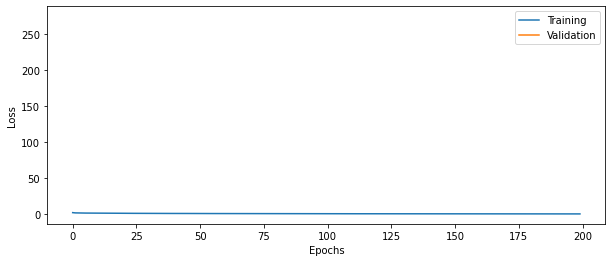

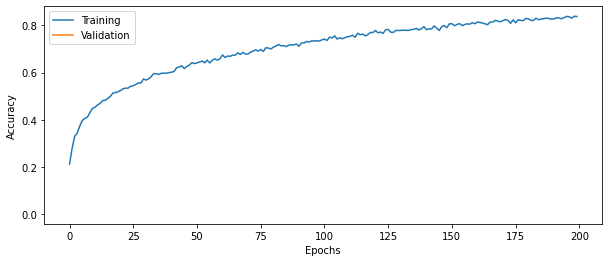

In [59]:
# Plot the history from the training run
plot_results(history6)

## Part 20: Plot misclassified images

Lets plot some images where the CNN performed badly, these cells are already finished.

In [60]:
# Find misclassified images
y_pred = model6.predict_classes(Xtest)
y_correct = np.argmax(Ytest,axis=-1)

miss = np.flatnonzero(y_correct != y_pred)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


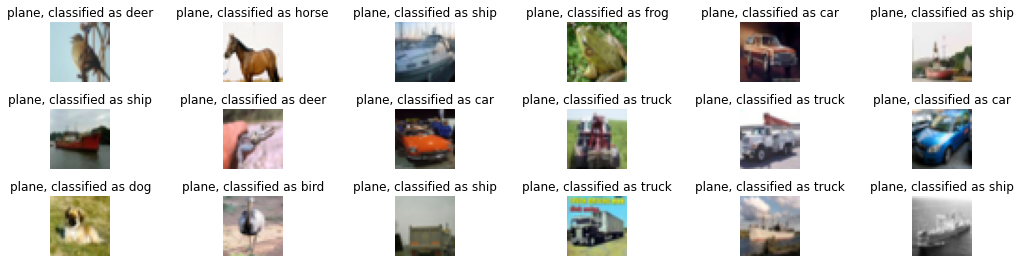

In [61]:
# Plot a few of them
plt.figure(figsize=(15,4))
perm = np.random.permutation(miss)
for i in range(18):
    im = (Xtest[perm[i]] + 1) * 127.5
    im = im.astype('int')
    label_correct = y_correct[perm[i]]
    label_pred = y_pred[perm[i]]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.axis('off')
    plt.title("{}, classified as {}".format(classes[label_correct], classes[label_pred]))
plt.show()

##  Part 21: Testing on another size

Question 27: This CNN has been trained on 32 x 32 images, can it be applied to images of another size? If not, why is this the case?
Answer : CNN has been trained with 32x32 images because dense layer is expecting the input of this size. CNN can be trained on images of any size.

Question 28: Is it possible to design a CNN that can be trained on images of one size, and then applied to an image of any size? How?
Answer: It is possible if we use only convolutional layer and avoid dense layers.

##  Part 22: Pre-trained 2D CNNs

There are many deep 2D CNNs that have been pre-trained using the large ImageNet database (several million images, 1000 classes). Import a pre-trained ResNet50 network from Keras applications. Show the network using `model.summary()`

Question 29: How many convolutional layers does ResNet50 have? 
Answer : 53 convolutional layers

Question 30: How many trainable parameters does the ResNet50 network have? 
Answer : 25,583,592 trainable parameters

Question 31: What is the size of the images that ResNet50 expects as input?
Answer : 224x224x3

Question 32: Using the answer to question 30, explain why the second derivative is seldom used when training deep networks.
Answer : Second derivative is called hessian method and to compute the 2nd derivative with many training parameters are very expensive.

Apply the pre-trained CNN to 5 random color images that you download and copy to the cloud machine or your own computer. Are the predictions correct? How certain is the network of each image class?
Answer : Yes, the predictions are correct. We got the results accordingly which show how certain the network for each image class is.

These pre-trained networks can be fine tuned to your specific data, and normally only the last layers need to be re-trained, but it will still be too time consuming to do in this laboration.

See https://keras.io/api/applications/ and https://keras.io/api/applications/resnet/#resnet50-function 

Useful functions

`image.load_img` in keras.preprocessing

`image.img_to_array` in keras.preprocessing

`ResNet50` in keras.applications.resnet50

`preprocess_input` in keras.applications.resnet50

`decode_predictions` in keras.applications.resnet50

`expand_dims` in numpy


In [46]:
# Your code for using pre-trained ResNet 50 on 5 color images of your choice. 
# The preprocessing should transform the image to a size that is expected by the CNN.

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

def image_pred(path):
    
  #ResNet50 model
    model = ResNet50(weights='imagenet')
  
  #load image
    original_image = image.load_img(path,target_size=(224,224)) #needs target size to resize the image we load
  #convert to numpy arrays
    original_image = img_to_array(original_image)

  #add extra dimension for the number of images
    original_image=np.expand_dims(original_image, axis=0) #used to add the number of images
    original_image= preprocess_input(original_image)

  #predictions
    prediction = model.predict(original_image)

  #list of tuples (class, description, probability)
    print('Predicted classes:', decode_predictions(prediction, top=3))

dog_pred = image_pred('dog.jpg')
cat_pred = image_pred('cat.png')
horse_pred= image_pred('horse.jpg')
baby_pred = image_pred('baby.jpg')
airplane_pred = image_pred('elephant.jpg')

Predicted classes: [[('n02089973', 'English_foxhound', 0.34407115), ('n02088364', 'beagle', 0.31513458), ('n02089867', 'Walker_hound', 0.3082493)]]
Predicted classes: [[('n02127052', 'lynx', 0.39137098), ('n02123045', 'tabby', 0.34023887), ('n02124075', 'Egyptian_cat', 0.13384134)]]
Predicted classes: [[('n02389026', 'sorrel', 0.9990152), ('n02110806', 'basenji', 0.00017970013), ('n02113978', 'Mexican_hairless', 8.740931e-05)]]
Predicted classes: [[('n03188531', 'diaper', 0.8439354), ('n02808304', 'bath_towel', 0.057659205), ('n03131574', 'crib', 0.042989604)]]
Predicted classes: [[('n02504458', 'African_elephant', 0.17831767), ('n02412080', 'ram', 0.17531286), ('n02504013', 'Indian_elephant', 0.1616113)]]


In [47]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________